# <p style='text-align: center;'> Using Stacked Long Short Term Memory with Principal Component Analysis for Short Term Prediction of Solar Irradiance based on Weather Patterns </p>
    
<p style='text-align: justify;'>&emsp;Energy production of photovoltaic (PV) system is heavily influenced by solar irradiance. Accurate prediction of solar irradiance leads to optimal dispatching of available energy resources and anticipating end-user demand. However, it is difficult to do due to fluctuating nature of weather patterns.</p>
<p style='text-align: justify;'>&emsp;In the study, neural network models were defined to predict solar irradiance values based on weather patterns. Models included in the study are artificial neural network, convolutional neural network, bidirectional long-short term memory (LSTM) and stacked LSTM. </p>
<p style='text-align: justify;'>&emsp;Preprocessing methods such as data normalization and principal component analysis were applied before model training. Regression metrics such as mean squared error (MSE), maximum residual error (max error), mean absolute error (MAE), explained variance score (EVS), and regression score function (R2 score), were used to evaluate the performance of model prediction. Plots such as prediction curves, learning curves, and histogram of error distribution were also considered as well for further analysis of model performance. All models showed that it is capable of learning unforeseen values, however, stacked LSTM has the best results with the max error, R2, MAE, MSE, and EVS values of 651.536, 0.953, 41.738, 5124.686, and 0.946, respectively.</p>

In [1]:
#import libaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
from sklearn.decomposition import PCA
from sklearn import metrics

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [6]:
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

<p style='text-align: justify;'>&emsp; The weather station deployed in Morong, Rizal consists of microcontrollers with sensors. It records the measurements of the considered weather parameters. Data gathering was conducted between September 2019 up to February 2020. Recorded measurements are stored in file as comma separated values (.csv) format. </p>

<p style='text-align: justify;'>&emsp; The output variable in the study is the solar irradiance. Solar irradiance is the amount of intensity from the sun, usually in the form of electromagnetic radiation, hitting power per unit each second. It is measured in terms of watt per square meter (W/m2). Pyranometer is used for measuring solar irradiance on plane surface. The pyranometer used in the study is a photodiode calibrated based on its spectral property. The photodiode is enclosed with Teflon diffuser for proper reading operations.  </p>
<p style='text-align: justify;'>&emsp; Features are windspeed, ambient light, humidity, ambient and station temperature, station altitude, and absolute and sea level pressure. To measure ambient temperature, a digital thermometer DS18B20 was used. It is a waterproof sensor used for capturing temperature even in wet conditions. It can sense data up to 125 degree Celsius. A piezoresistive sensor called BMP180 was used in capturing data about station altitude, sea level pressure and absolute pressure. DHT22 was used for capturing humidity and the weather station temperature. Illuminance is measured using digital ambient light sensor found in mobile phones called BH1750. Lastly, anemometer was used in measuring windspeed. The equipment outputs a voltage signal ranging from 0 to 5 V and transforms it into analog wind speed measurement. In the study, it can measure up to 30 m/s. </p> 


In [7]:
#load the dataset
df= pd.read_csv("weather.csv")

In [8]:
#split the loaded dataset to training and testing dataset
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

**Data Exploration**

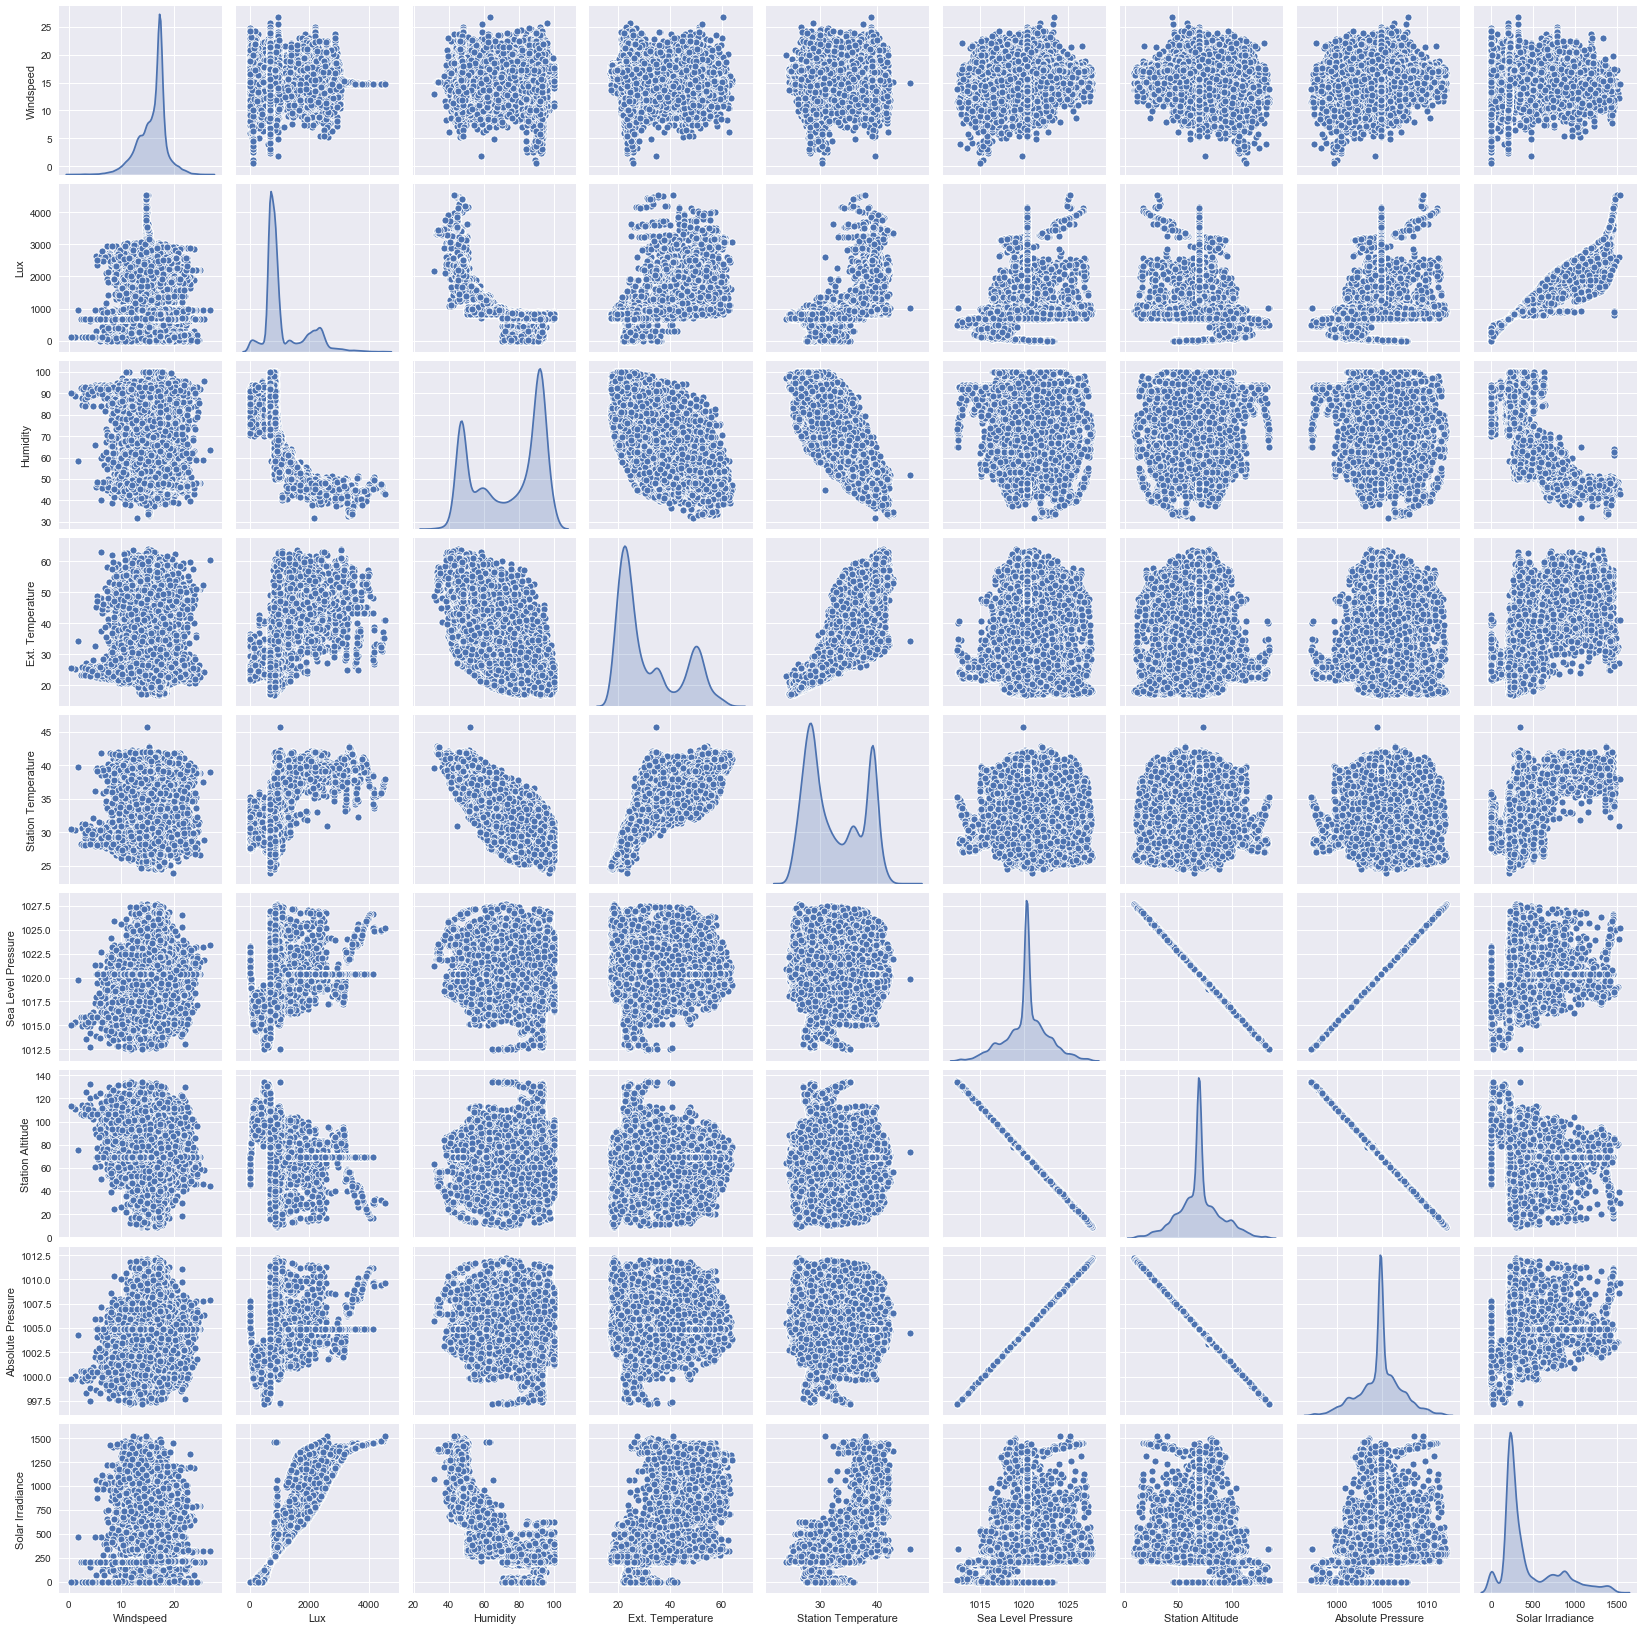

In [9]:
sns.pairplot(train_dataset[["Windspeed", "Lux", "Humidity", "Ext. Temperature",
                           "Station Temperature","Sea Level Pressure","Station Altitude",
                           'Absolute Pressure','Solar Irradiance']], diag_kind="kde")

<p style='text-align: justify;'>&emsp; Some of the parameters don’t have normal distribution like appearance such as humidity and temperature. Features such as wind speed, solar irradiance and illuminance are either skewed to the left or right. Pressure and station altitude are the only features that has almost a normal distribution appearance. Linear regression models are not enough to fit the data and requires more powerful processes such as neural networks. One of the assumptions for fitting regression models is the normality of all variables. Neural networks have no assumption on data, errors, or target. It has the capability to assume any function, even for complex patterns. Neural networks have activation function which is responsible for handling non-linearity of sequences. </p>

<p style='text-align: justify;'>&emsp; Observing the scatter plot between two parameters, it shows an upward trend between solar irradiance and illuminance. This implies that as sunlight intensifies, so is the illuminance. Humidity shows downward trend to solar irradiance and illuminance. Humidity strongly correlates with presence of rain. During rainfall, humidity increases due to evaporation. Rainfall implies less sunlight intensity and lower ambient temperature. It is also noted that station altitude and pressure possess downward linear relationship. 
Lastly, absolute pressure and sea level pressure shows a perfect upward linear relationship. This can imply the redundancy of using both features during model fitting </p>




**Correlation Map**

In [10]:
corrmap = train_dataset.corr()
corrmap.style.background_gradient(cmap='coolwarm')

,Windspeed,Lux,Humidity,Ext. Temperature,Station Temperature,Sea Level Pressure,Station Altitude,Absolute Pressure,Solar Irradiance
Windspeed,1.000000,-0.142921,0.183587,-0.183763,-0.209410,0.216142,-0.216118,0.215983,-0.197447
Lux,-0.142921,1.000000,-0.827916,0.783375,0.770359,0.109718,-0.110965,0.109748,0.939887
Humidity,0.183587,-0.827916,1.000000,-0.867723,-0.938232,-0.049239,0.050255,-0.049264,-0.823830
Ext. Temperature,-0.183763,0.783375,-0.867723,1.000000,0.923264,0.009297,-0.010754,0.009314,0.779729
Station Temperature,-0.209410,0.770359,-0.938232,0.923264,1.000000,-0.047479,0.046382,-0.047453,0.780584
Sea Level Pressure,0.216142,0.109718,-0.049239,0.009297,-0.047479,1.000000,-0.999878,0.999999,0.093281
Station Altitude,-0.216118,-0.110965,0.050255,-0.010754,0.046382,-0.999878,1.000000,-0.999878,-0.094557
Absolute Pressure,0.215983,0.109748,-0.049264,0.009314,-0.047453,0.999999,-0.999878,1.000000,0.093347
Solar Irradiance,-0.197447,0.939887,-0.823830,0.779729,0.780584,0.093281,-0.094557,0.093347,1.000000


<p style='text-align: justify;'>&emsp; Since the scatter plot of solar irradiance and illuminance trends upward, its regression coefficient has a value of 0.94. Since humidity shows downward trend with solar irradiance and illuminance, its regression coefficient are negative values. Ambient temperature has regression coefficient value of -0.8279 and 0.8238 to illuminance and solar irradiance, respectively. Humidity has inverse relationship with ambient temperature and station temperature with regression coefficient values -0.8667 and -0.9382, respectively. Windspeed has weak direct relationship with humidity, sea level pressure and absolute pressure having regression coefficient values of 0.1836, 0.2161, and 0.2159, respectively. </p>

**Histogram**

<p style='text-align: justify;'> This sections shows the histogram plot of each columns. This checks whether the column is normally distributed or not. </p>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B47ABA9EC8>,
      dtype=object)

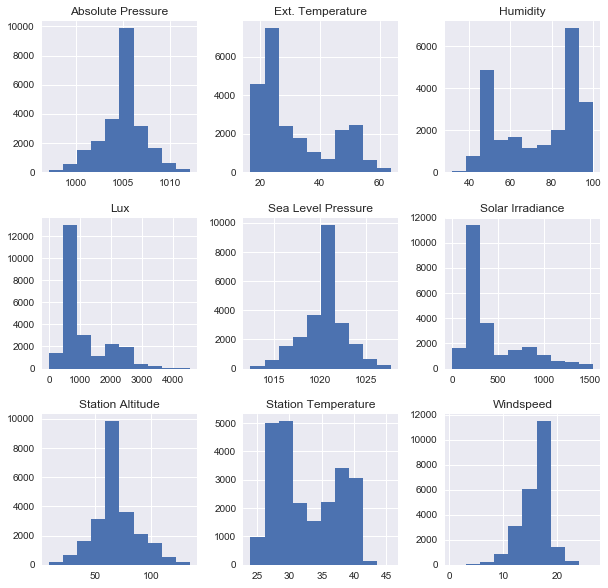

In [11]:
train_dataset.hist(figsize=(10,10))

**D’Agostino’s K^2 test**

<p style='text-align: justify;'>&emsp; Another assessment for normality used in the study is the D’Agostino’s K^2 test. D’Agostino’s K^2 test test determines if the random sample is drawn from normal distribution. In Python, Shapiro gives two values: one is the W-value or the test statistics, and the p value. If the p-value is less than the alpha value (0.05), it implies that the data is not normal </p>

<p style='text-align: justify;'>&emsp; Most of the columns failed to reject the null hypothesis, implying that all are not normally distributed.

In [12]:
from scipy.stats import normaltest

features =  ["Windspeed", "Lux", "Humidity", "Ext. Temperature",
             "Station Temperature","Sea Level Pressure","Station Altitude",
             'Absolute Pressure','Solar Irradiance']

for feature in features:
    data = df[feature]
# normality test
    stat, p = normaltest(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')


Statistics=3483.632, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=5760.296, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=171755.954, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=5829.874, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=216800.211, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=481.862, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=494.138, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=481.916, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=5440.148, p=0.000
Sample does not look Gaussian (reject H0)


In [13]:
#Statistics of the features.
train_stats = train_dataset.describe()
train_stats.pop("Solar Irradiance")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Windspeed,23565.0,15.923523,2.609527,0.5065,14.472800,16.653850,17.45755,26.6640
Lux,23565.0,1131.189262,710.135316,0.0245,694.874658,837.811983,1405.42826,4541.8745
Humidity,23565.0,74.166701,19.192323,31.8000,53.600000,81.400000,92.00000,100.0000
Ext. Temperature,23565.0,31.820714,12.171014,16.8200,22.240000,25.940000,42.94800,63.9400
Station Temperature,23565.0,32.644950,4.921048,23.9800,28.320000,31.200000,38.10000,45.8000
Sea Level Pressure,23565.0,1020.317992,2.313935,1012.4520,1019.214000,1020.325800,1021.52000,1027.7080
Station Altitude,23565.0,69.770067,19.107101,8.8000,59.800000,69.640000,79.00000,135.0000
Absolute Pressure,23565.0,1004.892734,2.278948,997.1420,1003.804000,1004.900000,1006.08000,1012.1680


In [14]:
train_labels = train_dataset.pop('Solar Irradiance')
test_labels = test_dataset.pop('Solar Irradiance')

In [15]:
#normalization of data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [16]:
train_final= normed_train_data.values
test_final = normed_test_data.values
train=train_labels.values
test=test_labels.values

**Principal Component Analysis**

<p style='text-align: justify;'>&emsp; Principal component analysis (PCA) is a statistical technique used for transforming higher dimensional dataset into lower dimension while retaining most of the information from the previous dataset. It is done by creating new and smaller uncorrelated variables called principal components from larger, correlated variables. Principal components maximize the variability of the data, leading to solving an eigenvector problem. PCA assumes that the sample size should be greater than 150 and there should be a correlation between features </p>

In [17]:
#principal component analysis
#There are four principal components
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(train_final)
pca.n_components_

4

**Reshape Input Data into 3 dimensions**

<p style='text-align: justify;'> LSTM and other deep learning models' input layers expect a 3D array of data during model fitting and model predictions, even if the array has only one feature. </p>
    
<p style='text-align: left;'>3D input consists of the following:
<p style='text-align: left;'> 1.) Samples = One sequence is equivalent to one sample. A batch comprises of one or more samples </p>
<p style='text-align: left;'> 2.) Time Step = One time step is equivalent to one point of observation in the sample.</p>
<p style='text-align: left;'> 3.) Features = One feature is equivalent to one observation at time step </p>

In [18]:
#Reshape input dataset to 3 dimensions since RNN, CNN, and Bidirectional LSTM requires 3D input
#For ANN, no need to feed 3D input array

pca_train = pca.transform(train_final)
pca_test = pca.transform(test_final)
X_train1 = np.expand_dims(train_final, axis=2)
X_test1 = np.expand_dims(test_final, axis=2)
X_train2 = np.expand_dims(pca_train, axis=2)
X_test2 = np.expand_dims(pca_test, axis=2)

<p style='text-align: justify;'> The following models are defined for PCA preprocessed input sequences </p>

**Convolutional Neural Network (CNN)**

<p style='text-align: justify;'>&emsp; The first layer of CNN is the Conv1D layer. This layer is used for sequences with fixed length segment such as time series data. It has 64 output filters used for convolution operation with kernel size of 2 units. It uses rectified linear unit as activation function. Next layer is the max pooling which is responsible for preventing overfit of learned features. It moves its windows steps 2 units, defined by its parameter “pool size”. The input sequence should be reshaped into 3 dimensions since it requires 3 parameters namely, batch size, steps, and features. It has a hidden layer with 50 nodes and output layer with one node. Adam algorithm was used as a loss function.</p>

In [19]:
def PCA_CNN():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(4, 1)))
    model.add(MaxPooling1D(pool_size=2))
    #model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))

   
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    

    return model

**Convolutional Neural Network (CNN)**
<p style='text-align: justify;'>&emsp; It is a variant of LSTM meant to improve the performance of traditional LSTM during sequence classification problems. It can preserve information both past and future timesteps since it trains 2 LSTMs. In the study, bidirectional LSTM uses 128 memory units and uses rectified linear unit as activation function. </p>

In [20]:
def PCA_bilstm():
    
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(4, 1)))
    model.add(Dense(1))
  
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    

    return model

**Stacked Long Short Term Memory (Stacked LSTM)**

<p style='text-align: justify;'>&emsp; Stacked LSTM possess multiple hidden LSTM layers and contains multiple memory units. In the study, it has 2 LSTM layers with 64 neurons as memory units. It uses rectified linear unit as activation function.</p>

In [21]:
def PCA_stkrnn():
    
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(4,1)))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))
    
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    
 
    return model

**Artificial Neural Network**

<p style='text-align: justify;'>&emsp; It consists of 2 hidden layers, with 64 nodes. Both hidden layers use rectified linear function as an activation function. Output layer has only one node. Rmsprop optimizer was used as a loss function which is responsible for searching the best weights during model training. Rmsprop is based on the moving average of square gradients and then dividing the gradient by the root average. </p>

In [22]:
def PCA_NN():
   
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(4,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    

    
    return model

**Metrics for assessing model performance**

<p style='text-align: justify;'> Regression metrics was used in assessing the performance of model prediction. These metrics are available from sklearn.metrics. Metrics used were as follows: </p>
<p style='text-align: left;'> 1.) Explained Variance Score: Computes the explained variance regression score. Best possible score is 1, and lower than 1 indicates worse performance.</p>
<p style='text-align: left;'> 2.) Max error: computes the maximum residual error. This metric is suitable for getting the worst case scenario between predicted and true value. A maximum error of 0 indicates a perfect fit model</p>
<p style='text-align: left;'> 3.) Mean absolute error: computes mean absolute error which serves as a risk metric for absolute error loss </p>
<p style='text-align: left;'> 4.) Mean squared error: computes mean squared error which serves as a risk metric for quadratic error loss  </p>
<p style='text-align: left;'> 5.) Regression score function: provides indication of good fit. It measures how unseen samples are likely to be predicted by model. Best score is 1.0 </p>

In [23]:
def metric_model(test, test_predictions):
    #maximum error
    maxe = max_error(test,test_predictions)
    #r2_score
    r2 = r2_score(test, test_predictions)
    #mean absolute error
    mae= mean_absolute_error(test, test_predictions)
    #mean squared error
    mse = mean_squared_error(test, test_predictions)
    #explained variance score
    evs = explained_variance_score(test, test_predictions)
    
    print('Max Error =%.3f' % maxe)
    print('R2 score =%.3f' % r2)
    print('MAE =%.3f' % mae)
    print('MSE =%.3f' % mse)
    print('EVS =%.3f' % evs)
    
    return maxe,r2,mae,mse,evs

In [24]:
pcacnn = PCA_CNN()
pcabilstm = PCA_bilstm()
pcastkrnn = PCA_stkrnn()
pcann= PCA_NN()


In [25]:
pcann.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [26]:
pcabilstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 128)               33792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________


In [27]:
pcastkrnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 64)             16896     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [28]:
pcacnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 64)             192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 50)             3250      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              51        
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
_________________________________________________________________


In [29]:
EPOCHS = 1000

**Model Fitting**

<p style='text-align: justify;'>&emsp;In all models, error decreases as the training progresses. The validation and training error are close to one another, which indicates that model is capable of learning values not present in the training set. For ANN, the validation and test error are close to one another which is an indication of a good fit and the model can learn more. It takes about 100 epochs to be stable in learning the input sequence. Its validation error is slightly higher than the training error and takes an estimated average error of 45 units. For CNN, however, the validation error is slightly lower than the training error. The model might overlook random samples during model prediction. It took 200 epochs for the CNN to be stable in learning. It is noted that its mean average error is estimated at around 80 units. Both Bi-LSTM and stacked LSTM has its validation error slightly higher than the training error. Also, both models have an estimated mean average error of 35 units. Bi-LSTM is the fastest model to get stable in learning, recorded at around 80 epochs. </p>

In [30]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


Epoch: 0, loss:153635.2188,  mae:276.8246,  mse:153635.2188,  val_loss:71451.2578,  val_mae:183.2269,  val_mse:71451.2578,  
..................................................................................................

Text(0, 0.5, 'MSE [Solar Irradiance ^2]')

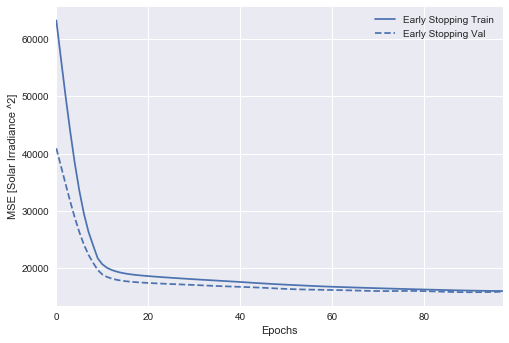

In [31]:
plot5 = pcacnn.fit(X_train2, train, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Early Stopping': plot5}, metric = "mse")
plt.ylabel('MSE [Solar Irradiance ^2]')

Text(0, 0.5, 'MAE [Solar Irradiance]')

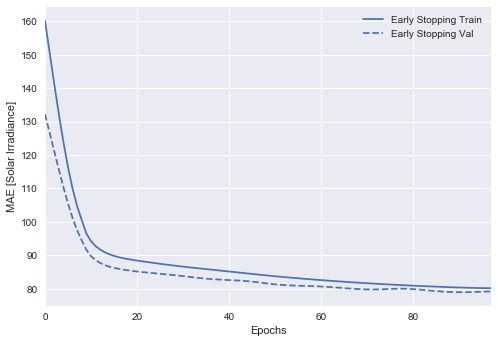

In [32]:
plotter.plot({'Early Stopping': plot5}, metric = "mae")
plt.ylabel('MAE [Solar Irradiance]')


Epoch: 0, loss:59113.2734,  mae:142.1088,  mse:59113.2734,  val_loss:13543.7217,  val_mae:68.0416,  val_mse:13543.7217,  
..................................................................

Text(0, 0.5, 'MSE [Solar Irradiance ^2]')

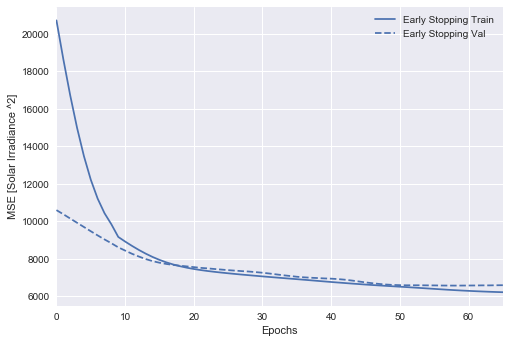

In [33]:
plot6 = pcabilstm.fit(X_train2, train, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Early Stopping': plot6}, metric = "mse")
plt.ylabel('MSE [Solar Irradiance ^2]')

Text(0, 0.5, 'MAE [Solar Irradiance]')

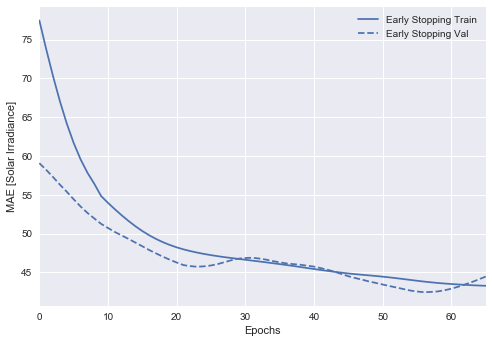

In [34]:
plotter.plot({'Early Stopping': plot6}, metric = "mae")
plt.ylabel('MAE [Solar Irradiance]')


Epoch: 0, loss:55736.3125,  mae:141.4827,  mse:55736.3125,  val_loss:17663.3516,  val_mae:86.3093,  val_mse:17663.3516,  
....................................................................................................
Epoch: 100, loss:5057.2046,  mae:38.2406,  mse:5057.2046,  val_loss:5195.7314,  val_mae:36.4396,  val_mse:5195.7314,  
......

Text(0, 0.5, 'MSE [Solar Irradiance ^2]')

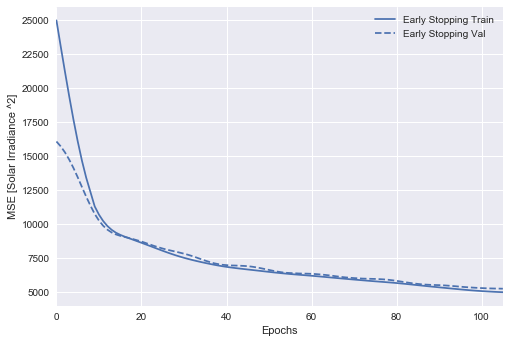

In [35]:
plot7 = pcastkrnn.fit(X_train2, train, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Early Stopping': plot7}, metric = "mse")
plt.ylabel('MSE [Solar Irradiance ^2]')

Text(0, 0.5, 'MAE [Solar Irradiance]')

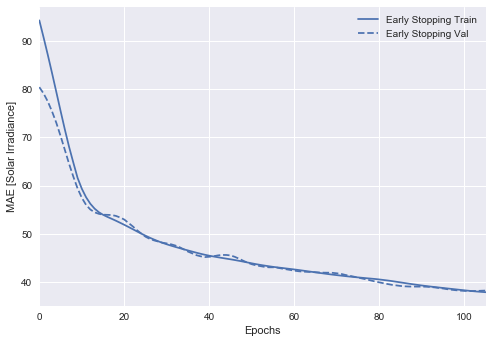

In [36]:
plotter.plot({'Early Stopping': plot7}, metric = "mae")
plt.ylabel('MAE [Solar Irradiance]')


Epoch: 0, loss:140606.0781,  mae:248.0737,  mse:140606.0781,  val_loss:14230.4844,  val_mae:78.5297,  val_mse:14230.4844,  
....................................................................................................
Epoch: 100, loss:6372.0229,  mae:42.5234,  mse:6372.0229,  val_loss:6455.5220,  val_mae:41.5470,  val_mse:6455.5220,  
.......................................

Text(0, 0.5, 'MSE [Solar Irradiance ^2]')

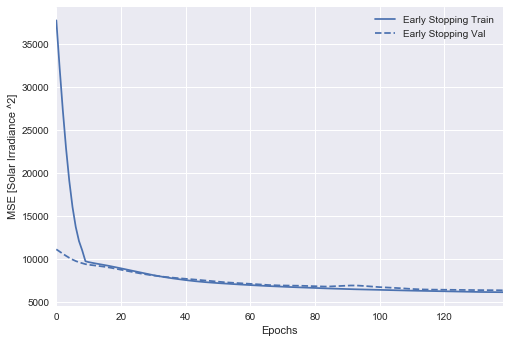

In [37]:
plot8 = pcann.fit(pca_train, train, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Early Stopping': plot8}, metric = "mse")
plt.ylabel('MSE [Solar Irradiance ^2]')

Text(0, 0.5, 'MAE [Solar Irradiance]')

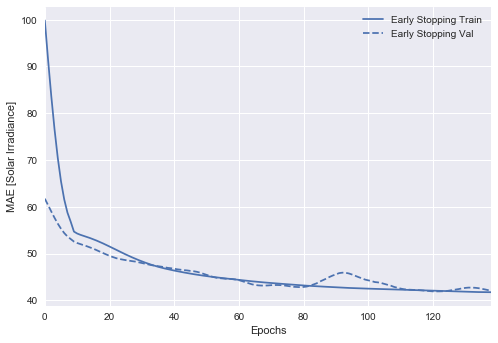

In [38]:
plotter.plot({'Early Stopping': plot8}, metric = "mae")
plt.ylabel('MAE [Solar Irradiance]')

**Plot of Predicted Values vs True Values of Validation Set**

<p style='text-align: justify;'>&emsp;This section shows how the model generalizes using the testing set by plotting the predicted values versus true values. A diagonal like appearance indicates good performance of model in prediction. Out of 4 models, only PCA-CNN has many outliers and doesn’t have a good diagonal appearance. This is because in observance of the plot of training history, the model might overfit and overlook future values. </p>

Text(0, 0.5, 'Predictions [Solar Irradiance]')

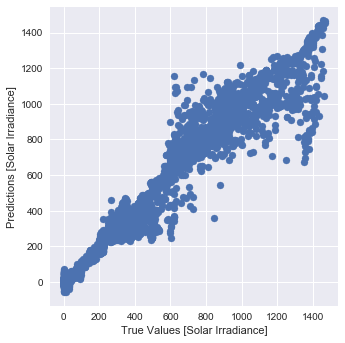

In [39]:
pcann_predictions = pcann.predict(pca_test).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test, pcann_predictions)
plt.xlabel('True Values [Solar Irradiance]')
plt.ylabel('Predictions [Solar Irradiance]')    

Text(0, 0.5, 'Predictions [Solar Irradiance]')

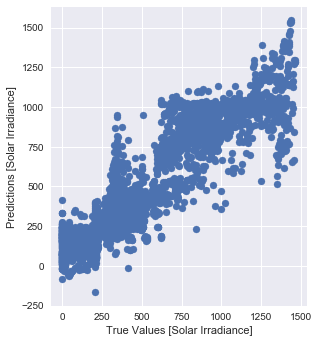

In [40]:
pcacnn_predictions = pcacnn.predict(X_test2).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test, pcacnn_predictions)
plt.xlabel('True Values [Solar Irradiance]')
plt.ylabel('Predictions [Solar Irradiance]')    

Text(0, 0.5, 'Predictions [Solar Irradiance]')

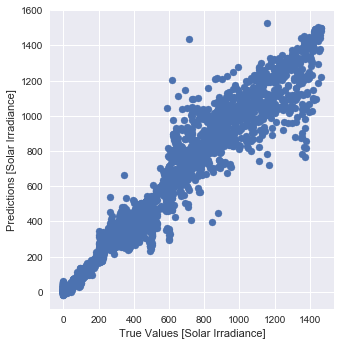

In [41]:
pcastkrnn_predictions = pcastkrnn.predict(X_test2).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test, pcastkrnn_predictions)
plt.xlabel('True Values [Solar Irradiance]')
plt.ylabel('Predictions [Solar Irradiance]')    

Text(0, 0.5, 'Predictions [Solar Irradiance]')

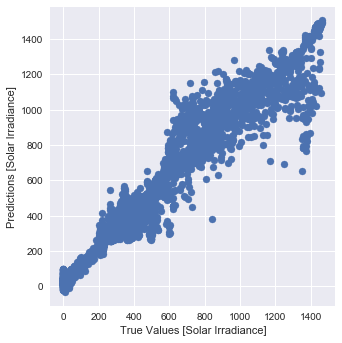

In [42]:
pcabilstm_predictions = pcabilstm.predict(X_test2).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test, pcabilstm_predictions)
plt.xlabel('True Values [Solar Irradiance]')
plt.ylabel('Predictions [Solar Irradiance]')    

**Histogram of Error Distributions**

<p style='text-align: justify;'>&emsp;This section shows the histogram of the error count of each model. All models produce a Gaussian like distribution appearance. Compared to other models, CNN has more spikes in error counts. </p>

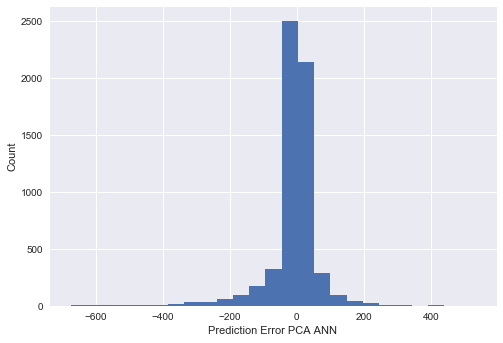

In [43]:
error5 = pcann_predictions - test
plt.hist(error5, bins = 25)
plt.xlabel("Prediction Error PCA ANN ")
_ = plt.ylabel("Count")

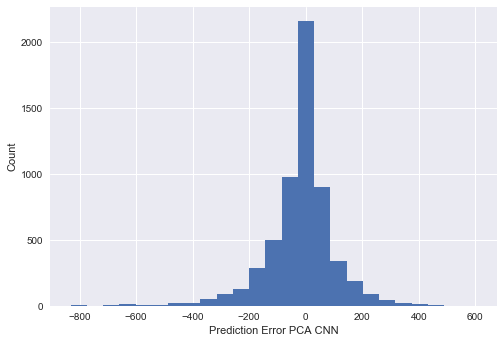

In [44]:
error6 = pcacnn_predictions - test
plt.hist(error6, bins = 25)
plt.xlabel("Prediction Error PCA CNN")
_ = plt.ylabel("Count")

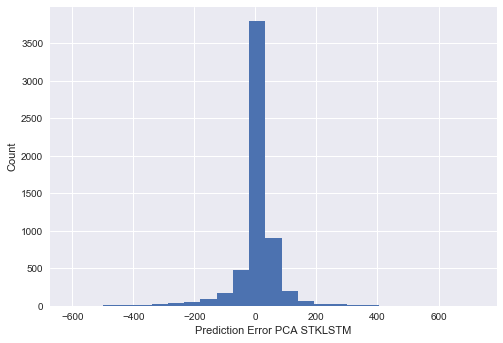

In [45]:
error7 = pcastkrnn_predictions - test
plt.hist(error7, bins = 25)
plt.xlabel("Prediction Error PCA STKLSTM")
_ = plt.ylabel("Count")

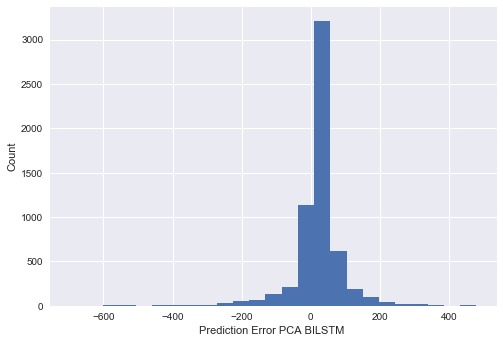

In [46]:
error8 = pcabilstm_predictions - test
plt.hist(error8, bins = 25)
plt.xlabel("Prediction Error PCA BILSTM ")
_ = plt.ylabel("Count")

**Regression Metrics Evaluation**

<p style='text-align: justify;'>&emsp; It is noted that CNN performs poorly compared to other models because of having highest values in error. This is because CNN is applicable to classification problems. Stacked LSTM has the best metrics evaluation result. It has the lowest error produced during model training and the highest score for regression score function. Therefore, it is the model that can predict the closest values found in the testing set. </p>

In [47]:
maxe_pcann,r2_pcann,mae_pcann,mse_pcann,evs_pcann = metric_model(test, pcann_predictions)

Max Error =674.515
R2 score =0.944
MAE =40.390
MSE =6098.595
EVS =0.945


In [48]:
maxe_pcacnn,r2_pcacnn,mae_pcacnn,mse_pcacnn,evs_pcacnn = metric_model(test, pcacnn_predictions)

Max Error =831.747
R2 score =0.858
MAE =79.224
MSE =15587.548
EVS =0.860


In [49]:
maxe_pcastkrnn,r2_pcacnn,mae_pcastkrnn,mse_pcastkrnn,evs_pcastkrnn = metric_model(test, pcastkrnn_predictions)

Max Error =724.282
R2 score =0.956
MAE =38.481
MSE =4842.852
EVS =0.956


In [50]:
maxe_pcabilstm,r2_pcabilstm,mae_pcabilstm,mse_pcabilstm,evs_pcabilstm = metric_model(test, pcabilstm_predictions)

Max Error =695.040
R2 score =0.941
MAE =49.962
MSE =6428.349
EVS =0.945
